In [1]:
from astropy.io import ascii,fits
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
import pandas as pd

%config InlineBackend.figure_format = 'retina'

In [2]:
hdulist_residuals_list = fits.open("FCC219_data/FCC219center_residuals_list_long.fits")

hdulist_stellar = fits.open("FCC219_data/FCC219_stellar_data.fits")

residuals_data = hdulist_residuals_list["PRIMARY"].data
stellar_data = hdulist_stellar["PRIMARY"].data

non_zero_index = np.squeeze(np.where(hdulist_residuals_list[0].data[:,0] != 0.))

In [3]:
# empty_bestfit = np.zeros((812*497, 1709))
# empty_cleaned = np.zeros((812*497, 1709))
# empty_emission = np.zeros((812*497, 1709))
empty_stellar = np.zeros((812*497, 1709))

for i,j in enumerate(non_zero_index):
#     empty_bestfit[j][:] = bestfit_data[i][0]
#     empty_cleaned[j][:] = cleaned_data[i][0]
#     empty_emission[j][:] = emission_data[i][0]
    empty_stellar[j][:] = stellar_data[i]
    
# bestfit_sum = np.sum(empty_bestfit,1)
# cleaned_sum = np.sum(empty_cleaned,1)
# emission_sum = np.sum(empty_emission,1)
stellar_sum = np.sum(empty_stellar, 1)

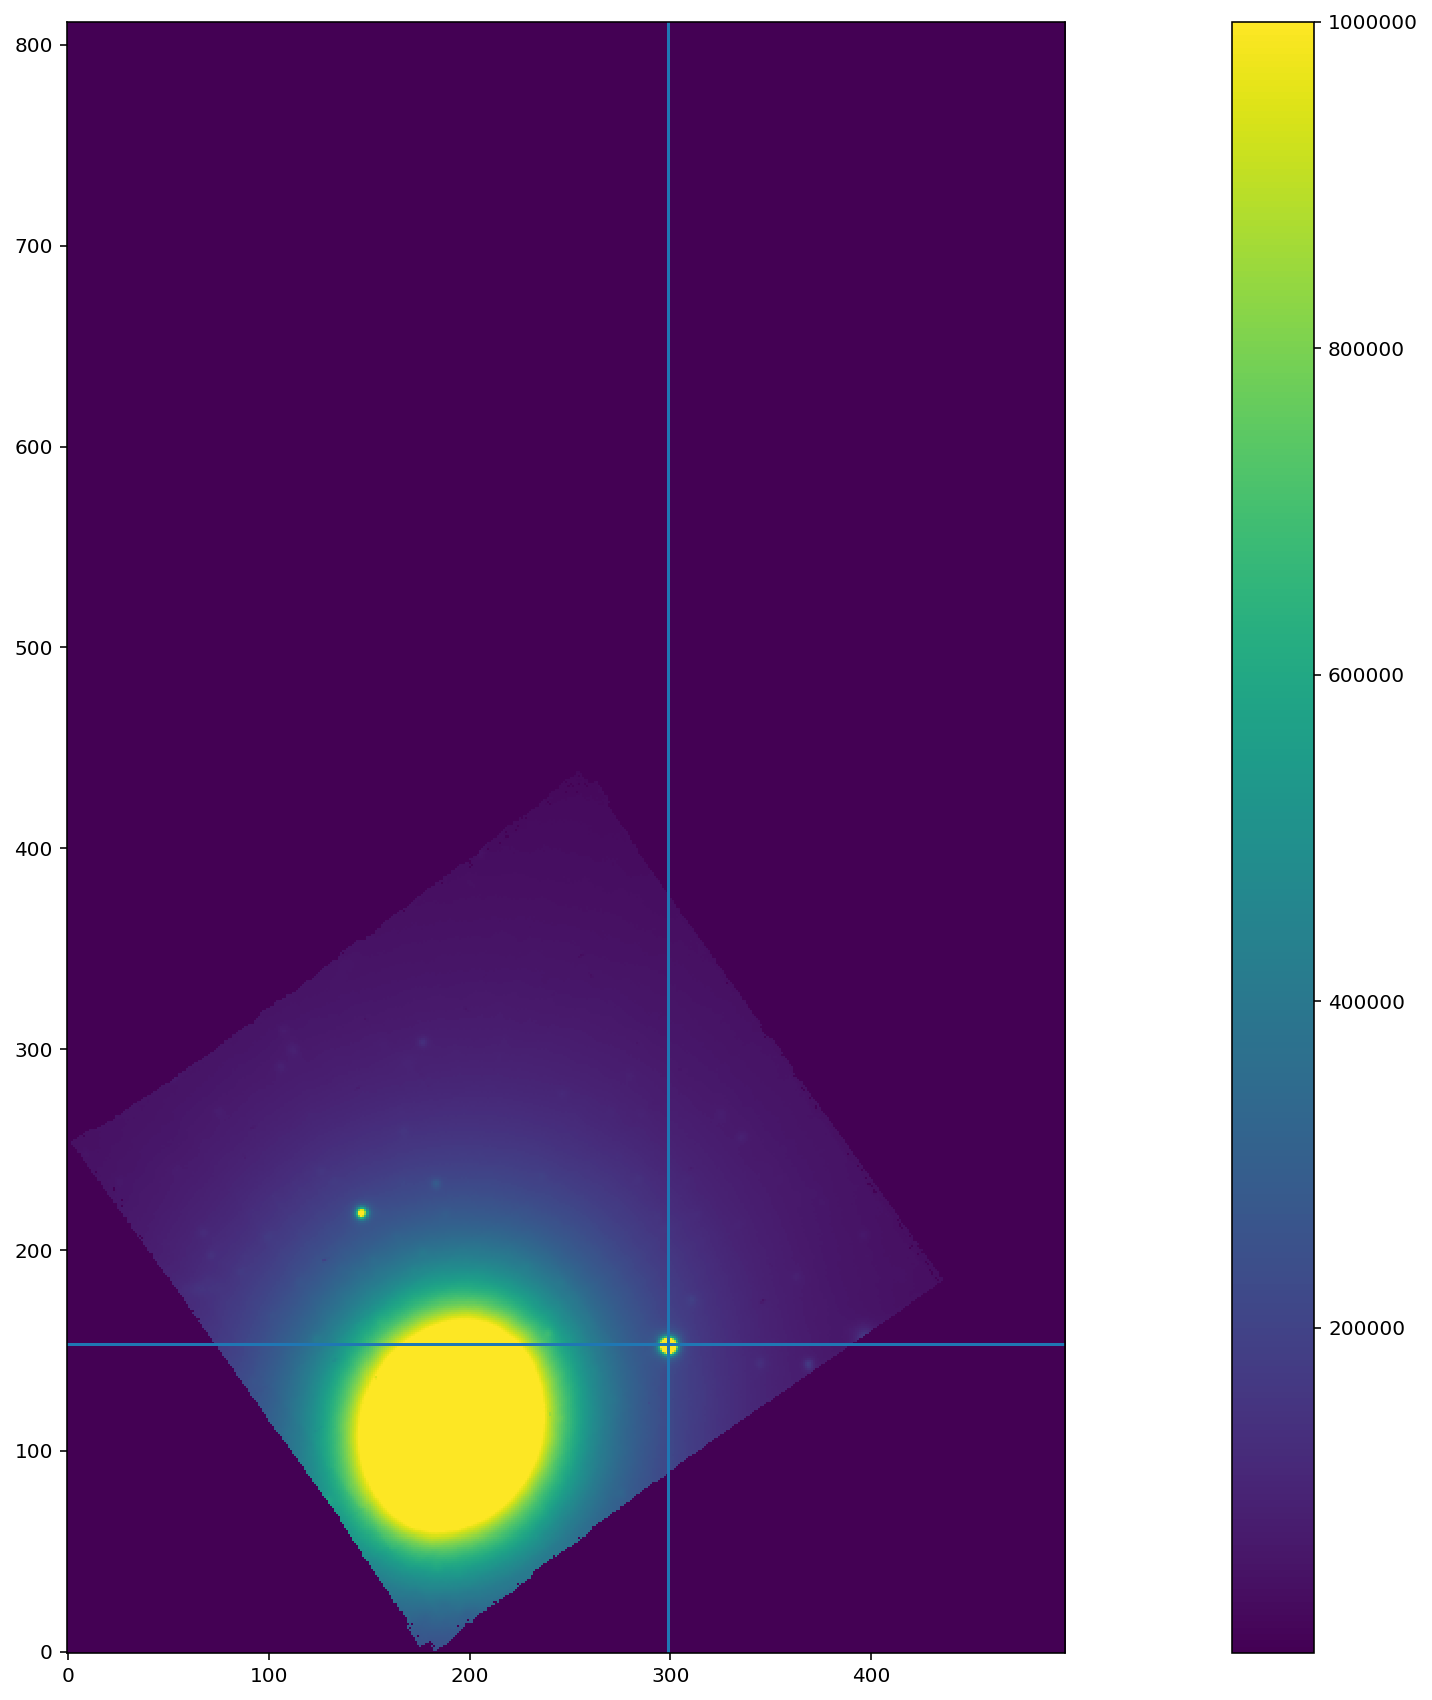

In [4]:
star_x = 299
star_y = 153

plt.figure(figsize=(30,15))
plt.imshow(stellar_sum.reshape((812,497)), origin="lower", vmin=1000, vmax=1e6)
plt.axhline(star_y)
plt.axvline(star_x)
plt.colorbar()


In [7]:
def PNe_spectrum_extractor(x, y, n_pix, data, x_d, wave):
    xc = round(x)
    yc = round(y)
    offset = n_pix // 2
    #calculate the x y coordinates of each pixel in n_pix x n_pix square around x,y input coordinates
    y_range = np.arange(yc - offset, (yc - offset)+n_pix, 1, dtype=int)
    x_range = np.arange(xc - offset, (xc - offset)+n_pix, 1, dtype=int)
    ind = [i * x_d + x_range for i in y_range]
    return data[np.ravel(ind)]

wavelength = np.load("FCC219_data/wavelenght.npy")
n_pix = 15
coordinates = [(n,m) for n in range(n_pix) for m in range(n_pix)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])
star = PNe_spectrum_extractor(star_x, star_y, n_pix, empty_stellar, 497,  wavelength)

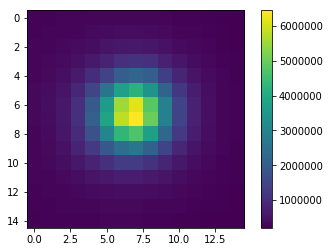

In [108]:
plt.imshow(np.sum(star,1).reshape(n_pix,n_pix))
plt.colorbar()

In [8]:
z = 0.006498

def spaxel_by_spaxel(params, x, data, error, spec_num):
    Amp = params["Amp"]
    wave = params["wave"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]

    Gauss_std = FWHM / 2.35482
    # Double peaked Gaussian model that fits the primary 5007 A and doublet 4959 A line, using redshift and known offset of lines to fit secondary peak.
    model = (Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - wave)** 2 / Gauss_std**2.) + (Amp/3.) * np.exp(- 0.5 * (x - (wave - 47.9399*(1+z)))** 2 / Gauss_std**2.)

    # Saves both the Residual noise level of the fit, alongside the 'data residual' (data-model) array from the fit.
    list_of_rN[spec_num] = np.std(data - model)
    data_residuals[spec_num] = data - model

    return (data - model) / error

list_of_std = np.abs(np.std(star ,1))
input_errors = [np.repeat(item, len(wavelength)) for item in list_of_std] # Intially use the standard deviation of each spectra as the uncertainty for the spaxel fitter.

# Setup numpy arrays for storage of best fit values.
best_fit_A = np.zeros((len(star),2))
list_of_rN = np.zeros(len(star))
data_residuals = np.zeros((len(star),len(wavelength)))
obj_residuals = np.zeros((len(star),len(wavelength)))

# setup LMfit paramterts
params = Parameters()
params.add("Amp",value=700., min=0.001)
params.add("wave", value=5030, vary=True) # wavelength (mean) starts at redshift informed position, transforming 5007 to the expected value. set to a range of 40 A around starting position.
params.add("FWHM", value=2.81, vary=False) # Line Spread Function
params.add("Gauss_bkg", value=0.001, vary=False)
params.add("Gauss_grad", value=0.001, vary=False)

for i in np.arange(0, len(star)):
    fit_results = minimize(spaxel_by_spaxel, params, args=(wavelength, star[i], input_errors[i], i), nan_policy="propagate")
    best_fit_A[i] = [fit_results.params["Amp"], fit_results.params["Amp"].stderr]
    obj_residuals[i] = fit_results.residual

gauss_A = np.array([A[0] for A in best_fit_A])
A_err = np.array([A[1] for A in best_fit_A])
A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19

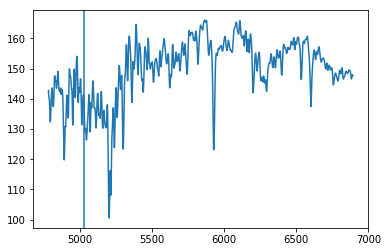

In [206]:
plt.plot(wavelength, star[211])
plt.axvline(5030)

In [211]:
gauss_A[22]

700.0109869495388

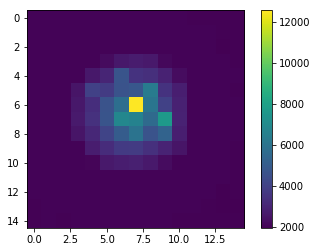

In [197]:
plt.imshow(Gauss_F.reshape(n_pix,n_pix))
plt.colorbar()

In [320]:
wavelength[220:280]

array([5011.6895, 5012.765 , 5013.841 , 5014.912 , 5015.9883, 5017.06  ,
       5018.1367, 5019.2085, 5020.2856, 5021.3584, 5022.436 , 5023.509 ,
       5024.587 , 5025.6606, 5026.739 , 5027.813 , 5028.892 , 5029.971 ,
       5031.046 , 5032.1255, 5033.2007, 5034.281 , 5035.356 , 5036.4365,
       5037.5127, 5038.5938, 5039.6704, 5040.752 , 5041.8286, 5042.9106,
       5043.9927, 5045.0703, 5046.1533, 5047.2314, 5048.3145, 5049.393 ,
       5050.4766, 5051.5557, 5052.6396, 5053.719 , 5054.8037, 5055.884 ,
       5056.9688, 5058.0537, 5059.1343, 5060.22  , 5061.3013, 5062.387 ,
       5063.4688, 5064.5557, 5065.6377, 5066.7246, 5067.807 , 5068.8945,
       5069.9775, 5071.066 , 5072.154 , 5073.238 , 5074.326 , 5075.41  ],
      dtype=float32)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 225
    # variables        = 6
    chi-square         = 3.9752e+08
    reduced chi-square = 1815146.73
    Akaike info crit   = 3248.54584
    Bayesian info crit = 3269.04245
[[Variables]]
    moff_amp:  182226.837 +/- 930.199281 (0.51%) (init = 900000)
    x_0:       6.62915621 +/- 0.00631628 (0.10%) (init = 7.5)
    y_0:       6.77220564 +/- 0.00631624 (0.09%) (init = 7.5)
    FWHM:      4.06719463 +/- 0.01821948 (0.45%) (init = 4)
    beta:      3.41992903 +/- 0.16733194 (4.89%) (init = 1.4)
    bkg:       7297.19953 +/- 220.066970 (3.02%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(moff_amp, FWHM) = -0.816
    C(beta, bkg)      =  0.810
    C(moff_amp, beta) = -0.705
    C(FWHM, beta)     =  0.649
    C(moff_amp, bkg)  = -0.528
    C(FWHM, bkg)      =  0.258
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # 

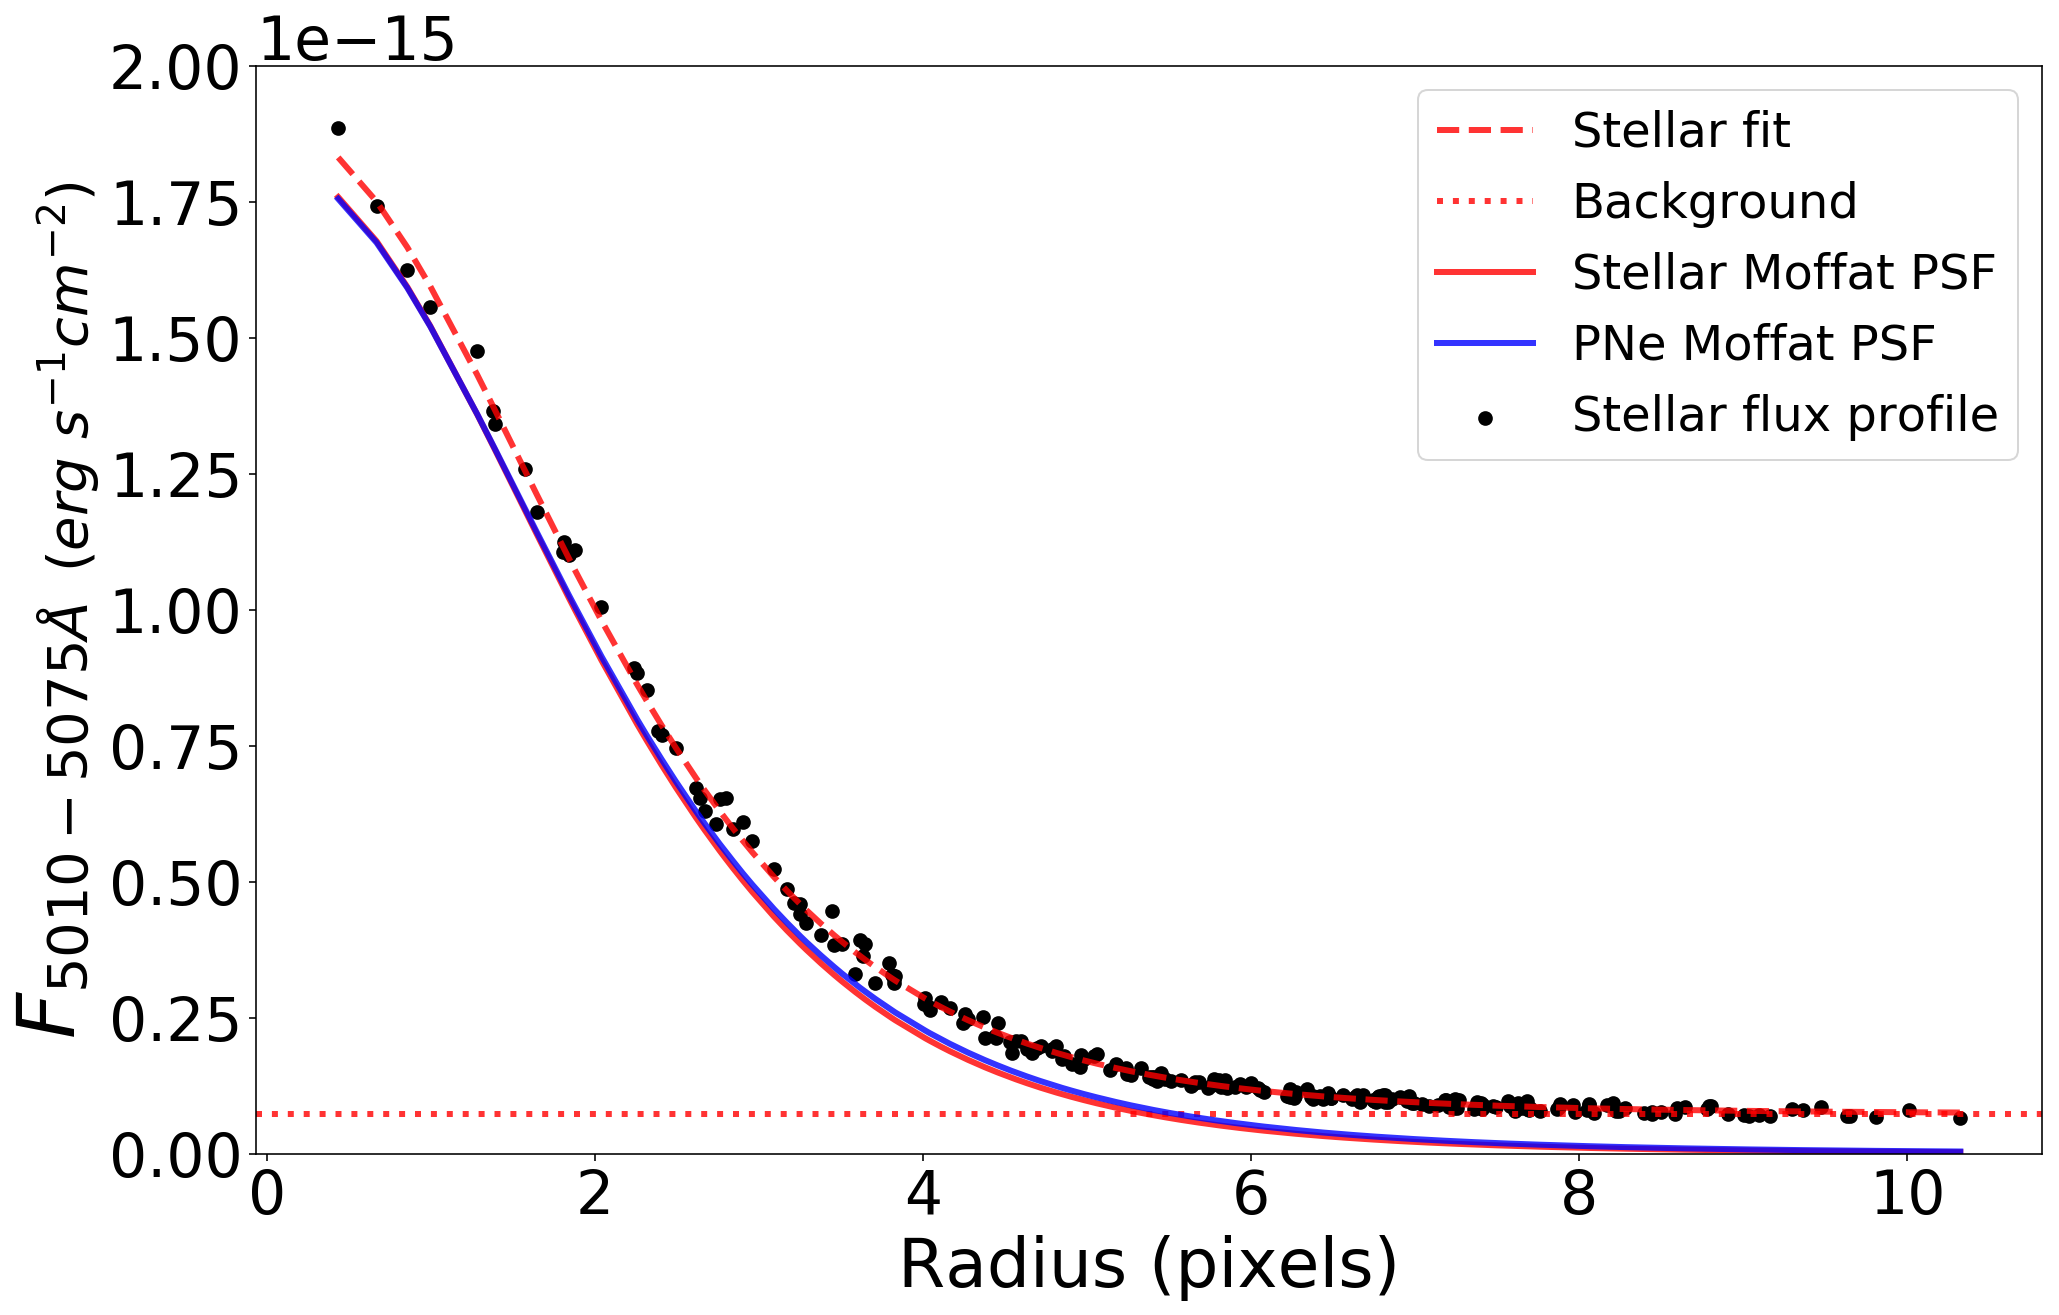

In [19]:
#star_ = Gauss_F
star_ = np.sum(star[:,220:280],1)
coordinates = [(n,m) for n in range(n_pix) for m in range(n_pix)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

#list_of_residuals = np.zeros(len())
list_of_flux = []

def residuals(params):
    moff_amp = params["moff_amp"]
    x_0 = params["x_0"]
    y_0 = params["y_0"]
    FWHM = params["FWHM"]
#     gamma = params["gamma"]
    beta = params["beta"]
    bkg = params["bkg"]

    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
    model = moff_amp * (1 + rr_gg)**(-beta) + bkg
    list_of_flux.clear()
    list_of_flux.append(model)
    #list_of_residuals[spec_num] = np.std(data - model)
    
    return star_ - model

# Star initial parameters
S_params = Parameters()
S_params.add('moff_amp', value=900000., min=0.0001)
S_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('FWHM', value=4., min=0.001, max=30., vary=True)
S_params.add("beta", value=1.4, min=0.001, vary=True)
S_params.add("bkg", value=1000., min=0.00001, vary=True)

#list_of_std = [np.abs(np.std(spec)) for spec in flat_raw_data]
#input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

S_results = minimize(residuals, S_params, method="leastsq", nan_policy="propagate")
print(report_fit(S_results))
star_model = list_of_flux

star_residuals = residuals(S_results.params)
star_model = star_ - star_residuals

P_params = Parameters()
P_params.add('moff_amp', value=182226.837, min=0.0001,)
P_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('FWHM', value=4.1, min=0.001, max=30., vary=False)
P_params.add("beta", value=3.077, min=0.001, vary=False)
P_params.add("bkg", value=S_results.params["bkg"].value, vary=True)

P_results = minimize(residuals, P_params, method="leastsq", nan_policy="propagate")
print(report_fit(P_results))
PNe_model = list_of_flux

PNe_residuals = residuals(P_results.params)
PNe_model = star_ - PNe_residuals


rad= np.sqrt((x_fit - S_results.params["x_0"])**2 + (y_fit - S_results.params["y_0"])**2)
plt.figure(figsize=(16,10))
plt.xlabel("Radius (pixels)", fontsize=34)
plt.ylabel("$ F_{5010-5075\AA} \ {}_{(erg \ s^{-1} cm^{-2})}$", fontsize=40)
plt.scatter(rad, star_*1e-20, color="k", label="Stellar flux profile", s=40)
plt.ylim(0,2e-15)
plt.tick_params(labelsize = 30)
ax = plt.gca()
ax.yaxis.offsetText.set_fontsize(30)


# star fit
ind = rad.argsort()
star_model_sorted = star_model[ind]
rad_sorted = rad[ind]
plt.plot(rad_sorted,( star_model_sorted)*1e-20, c="r", ls="dashed", lw="3", alpha=0.8, label="Stellar fit")
plt.axhline((S_results.params["bkg"].value)*1e-20, c="r", ls="dotted", lw="3", alpha=0.8, label="Background")
plt.plot(rad_sorted,( star_model_sorted- S_results.params["bkg"].value)*1e-20, c="r", lw="3", alpha=0.8, label="Stellar Moffat PSF")
# PNe fit
ind = rad.argsort()
PNe_model_sorted = PNe_model[ind]
plt.plot(rad_sorted, (PNe_model_sorted- P_results.params["bkg"].value)*1e-20, c="b", lw="3", alpha=0.8, label="PNe Moffat PSF")

#mini = lmfit.Minimizer(residuals, S_results.params)
#ci = lmfit.conf_interval(mini, S_results)
#lmfit.printfuncs.report_ci(ci)


#plt.scatter(rad, star_model*1e-20, color="r", label="Best-fit Moffat model")
plt.legend(prop={"size":24})
# plt.savefig("Plots/FCC219/Star_radial_PSF_fit.png")

In [20]:
print("Star_: ", np.sum(star_))
print("Star PSF total flux: ", np.sum(star_model))
print("PNe PSF total flux:  ", np.sum(PNe_model))

print("Star Diff: ", np.sum(star_ - star_model), (np.sum(star_ - star_model) / np.sum(star_) )*100, "%")
print("PNe Diff: ", np.sum(star_ - PNe_model), np.abs((np.sum(star_ - PNe_model) / np.sum(star_) ))*100, "%")
print("Model Diff: ", np.abs(np.sum(star_model - PNe_model)), (np.abs(np.sum(star_model - PNe_model))/ np.sum(star_))*100, "%" )

Star_:  5892495.285775247
Star PSF total flux:  5892495.285284612
PNe PSF total flux:   5892495.284600973
Star Diff:  0.000490635453388677 8.326446260773316e-09 %
PNe Diff:  0.0011742747219614103 1.9928309909660225e-08 %
Model Diff:  0.0006836392667537439 1.1601863618017317e-08 %


In [330]:
(649383.4257809028 / 5892495.285198533 )*100


11.020516680125327

In [ ]:
def residuals(params):
    moff_amp = params["moff_amp"]
    x_0 = params["x_0"]
    y_0 = params["y_0"]
    FWHM = params["FWHM"]
#     gamma = params["gamma"]
    beta = params["beta"]
    bkg = params["bkg"]

    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
    model = moff_amp * (1 + rr_gg)**(-beta) + bkg
    list_of_flux.clear()
    list_of_flux.append(model)
    #list_of_residuals[spec_num] = np.std(data - model)
    
    return star_ - model #/ np.std(flatten(data))

mini = lmfit.Minimizer(residuals, S_params)
result = mini.minimize(method="leastsq")
print(lmfit.fit_report(result.params))

In [265]:
ci = lmfit.conf_interval(mini, result)
lmfit.printfuncs.report_ci(ci)


             99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 moff_amp:-3147.68966-2255.18200-1447.14507182469.84194+974.12584+1806.53265+2739.53196
 x_0     :  -0.01978  -0.01361  -0.00811   6.62915  +0.00812  +0.01362  +0.01979
 y_0     :  -0.02003  -0.01386  -0.00824   6.77220  +0.00825  +0.01387  +0.02003
 FWHM    :  -0.04955  -0.03177  -0.01569   4.05918  +0.03174  +0.04780  +0.06561
 beta    :  -0.35532  -0.22289  -0.09430   3.30690  +0.34479  +0.51822  +0.72794
 bkg     :-630.04484-401.00156-198.571767204.51222+375.60766+562.91929+766.15445


In [271]:
ci["beta"]

[(0.9973002039367398, 2.9515808539172506),
 (0.9544997361036416, 3.0840060482870735),
 (0.6826894921370859, 3.2125935059146364),
 (0.0, 3.3068973625847535),
 (0.6826894921370859, 3.6516891801102584),
 (0.9544997361036416, 3.8251146178296724),
 (0.9973002039367398, 4.034841217103994)]

# Comparison with literature PNe

In [155]:
gal_hdulist = fits.open("FCC219_data/FCC219center.fits")

x_y_list = np.load("exported_data/FCC219/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN", "rad D", "Chi^2", "Include"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers

hdr_wcs = gal_hdulist[1].header
wcs_obj = WCS(hdr_wcs, naxis=2)
#
for i in np.arange(0, 1):#len(x_PNe)):
    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (54.71028648, -35.59545676)>


In [282]:
PNe_hdulist = fits.open("PNe1404.fit")
list_1404 = PNe_hdulist[1].data
list_1404 = list_1404[-47:]

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(PNe_1404)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(RA_1404[i], u.hourangle), dec=Angle(Dec_1404[i], u.deg), frame="fk5"), wcs_obj)

RA_1404 =    [PNe_1404[i][7] for i in np.arange(0,len(PNe_1404))]
Dec_1404 =   [PNe_1404[i][8] for i in np.arange(0,len(PNe_1404))]
m5007_1404 = [PNe_1404[i][4] for i in np.arange(0,len(PNe_1404))]

Text(0, 0.5, 'Dec')

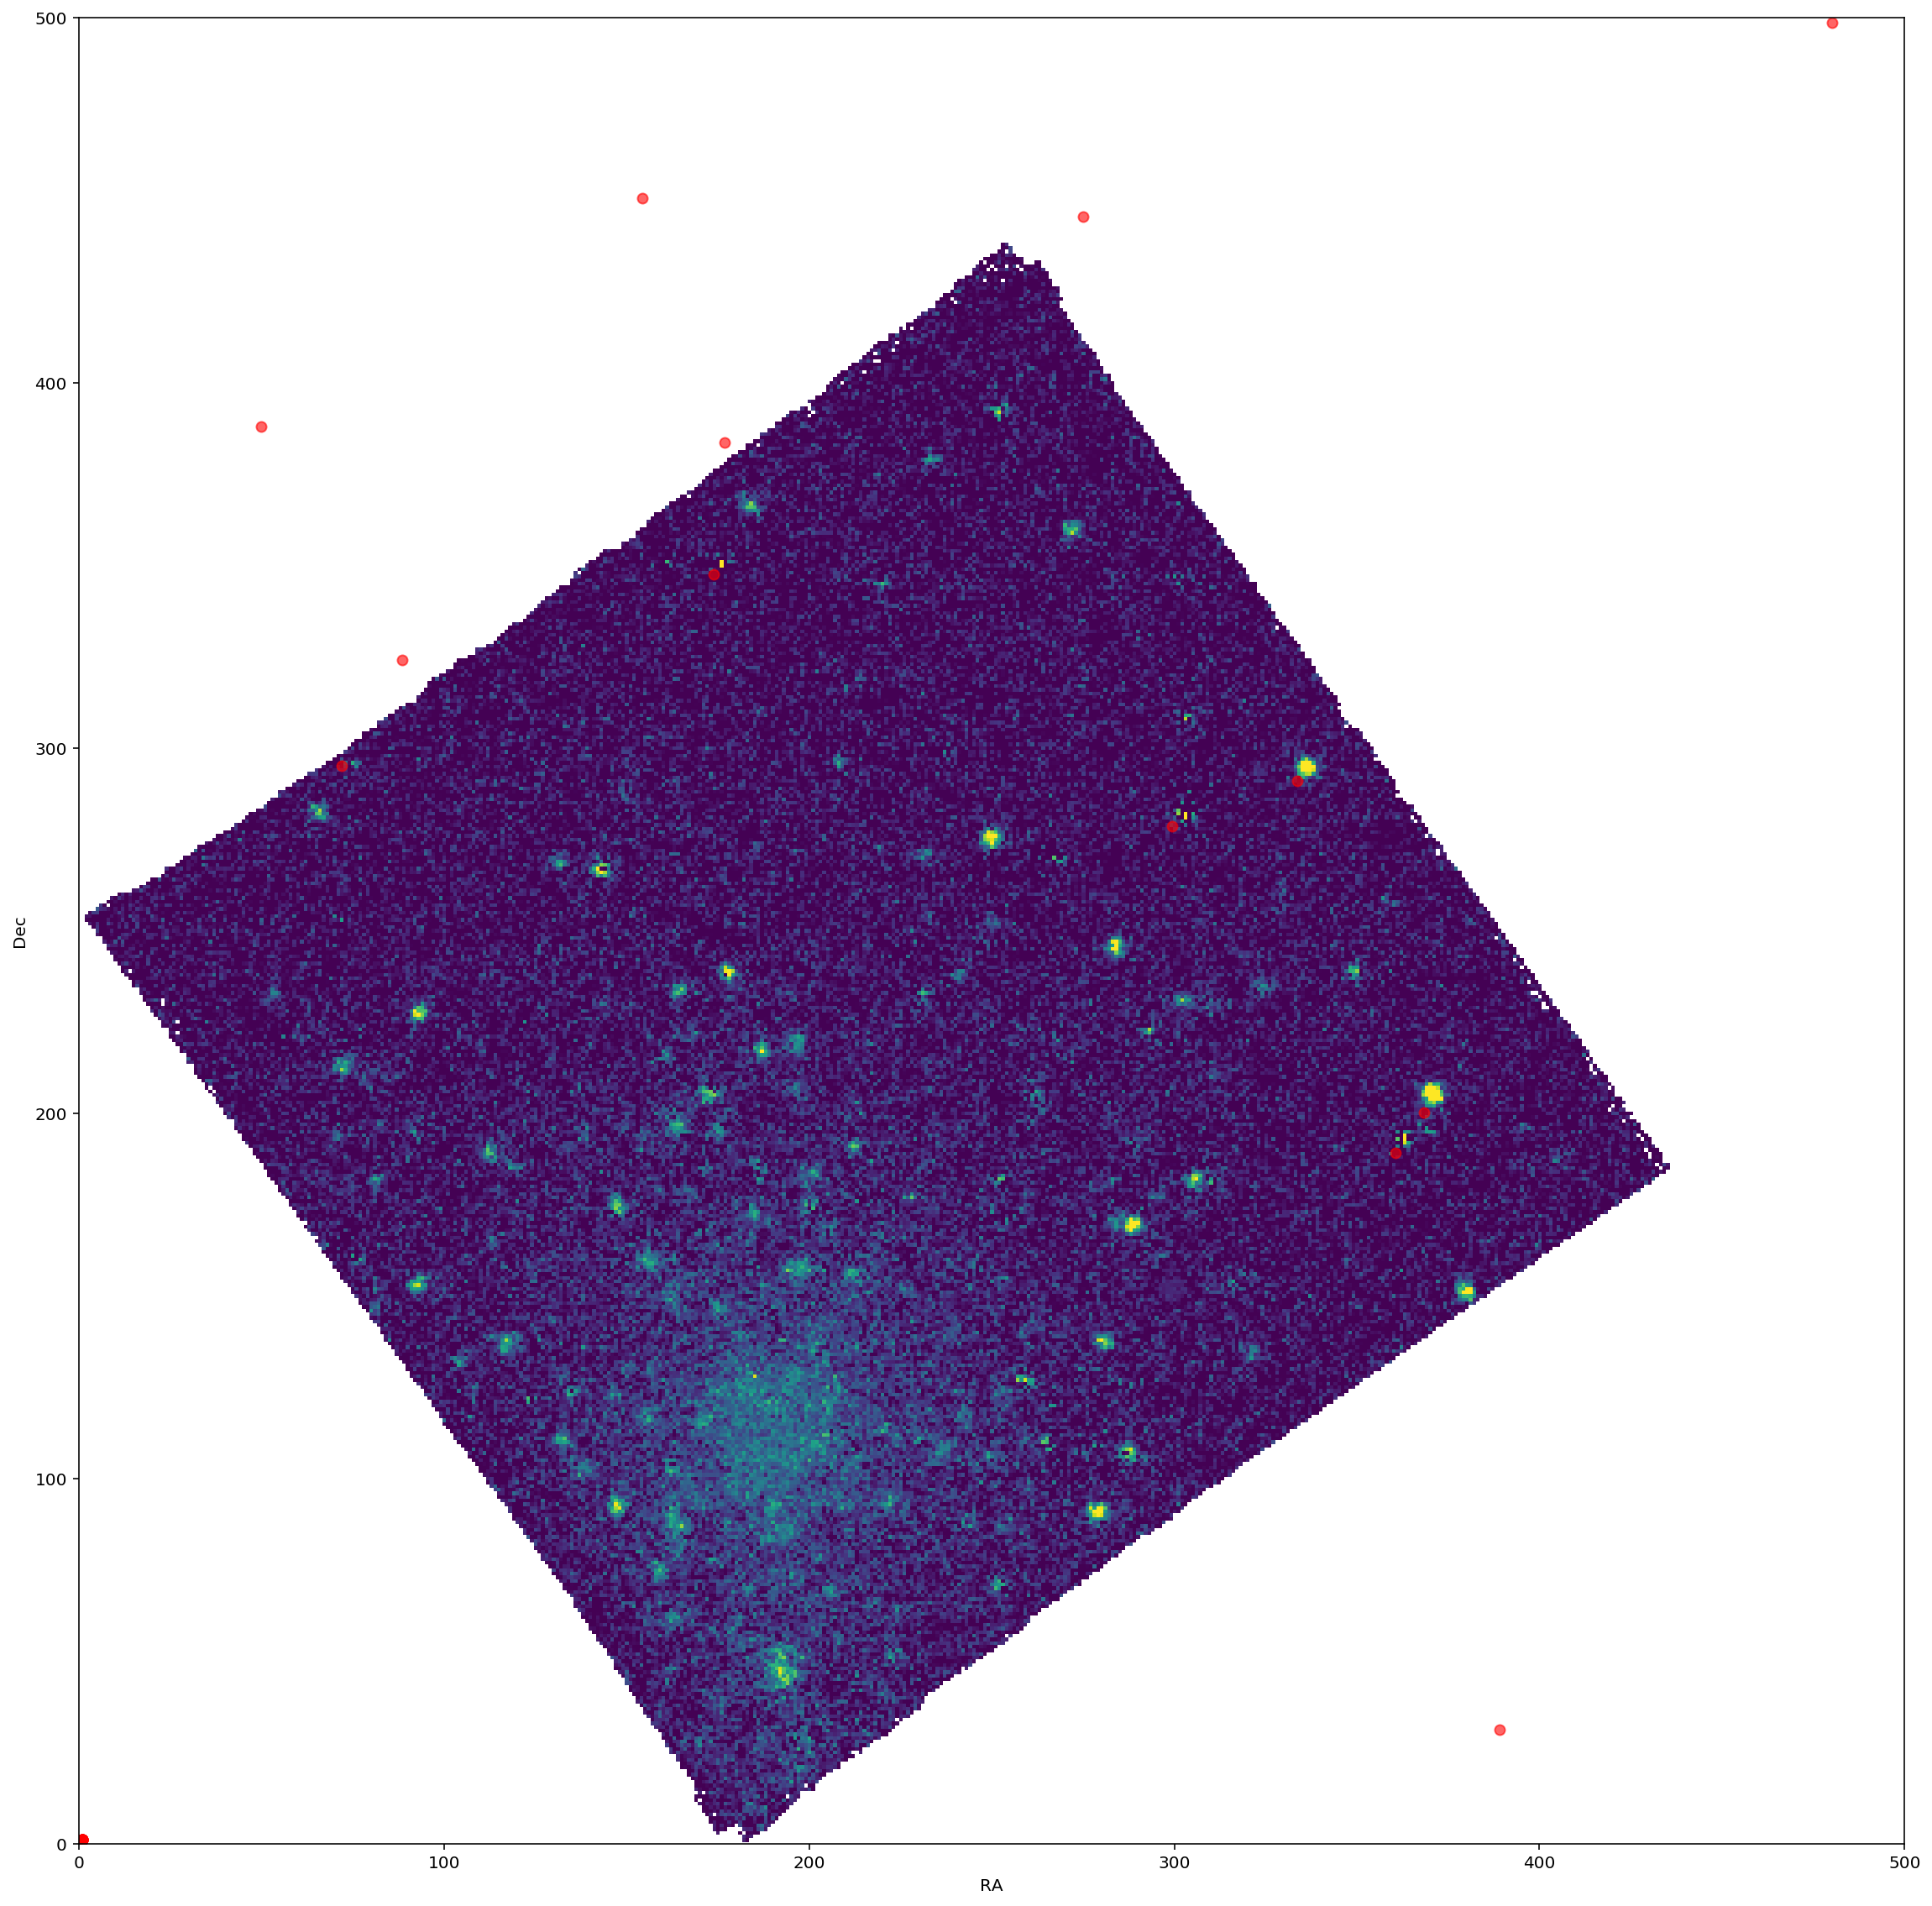

In [341]:
x_data = 497
y_data = 812
gal_name = "FCC219"
gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
plt.xlim(0,500)
plt.ylim(0,500)
plt.xlabel('RA')
plt.ylabel('Dec')

In [147]:
smallest_sep = []
for r,d in zip(RA_1404, Dec_1404):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(r, d, frame="fk5")
        c2 = SkyCoord(r1, d1, frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)



In [148]:
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
print(indx[[2,  4,  7, 43]])

PNe_df.loc[indx[[2,  4,  7, 43]]]

[0.00027584 0.00030865 0.00024984 0.00077906 0.00024664]
(array([ 2,  4,  7, 38, 43]),)


In [325]:
3.453149e-17*10**((3.56*(0.037))/2.5)

3.898551881475328e-17

In [304]:
-2.5 * np.log10(3.453149e-17) - 13.74 #- 0.0534

27.414461704660894

In [326]:
-2.5 * np.log10(3.898551881475328e-17) - 13.74 #- 0.0534

27.282741704660893

In [342]:
my_m5007 = [27.647, 27.101, 27.391, 27.414]
print("m 5007 from lit: ", np.array(m5007_1404)[[2,  4,  7, 43]])
print("m 5007 from me : ", my_m5007)
print("Diff in m5007  : ", np.array(m5007_1404)[[2,  4,  7, 43]] - my_m5007)

m 5007 from lit:  [26.79 26.83 26.98 27.68]
m 5007 from me :  [27.647, 27.101, 27.391, 27.414]
Diff in m5007  :  [-0.857 -0.271 -0.411  0.266]


<ErrorbarContainer object of 3 artists>

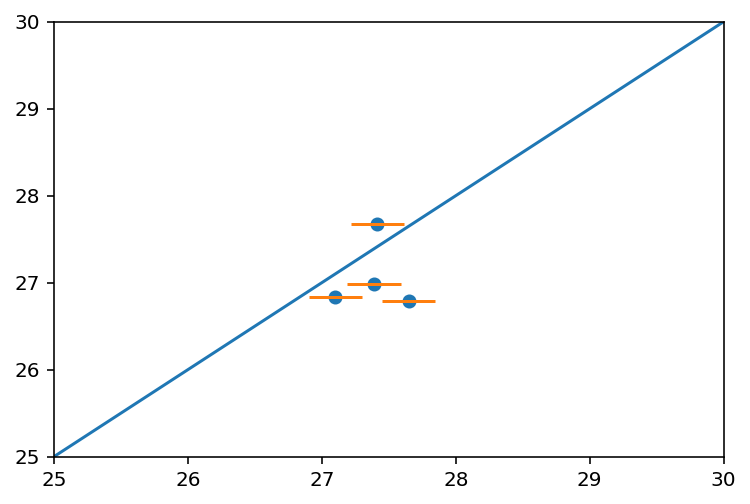

In [337]:
plt.scatter(my_m5007, np.array(m5007_1404)[[2,  4,  7, 43]])
plt.ylim(25,30)
plt.xlim(25,30)
plt.plot(np.arange(25,31),np.arange(25,31))
plt.errorbar(my_m5007, np.array(m5007_1404)[[2,  4,  7, 43]], 0, 0.2, ls="")

In [300]:
(2.5/((1.38)-1))*np.log10((1/2.85)*4.762739)

1.467183701605599